#Evaluación del riesgo de mercado en una cartera de acciones de entidades financieras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 16.3 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Resultados del análisis de riesgo de mercado
--------------------------------------------------
Value at Risk: -4.0844
Expected Shortfall: -5.5047
Maximum Drawdown: 35.3036
VaR Paramétrico: -3.5370
Volatilidad: 1.5391
Volatilidad Anualizada: 24.4319
Asimetría: -0.2371
Curtosis: 1.9599


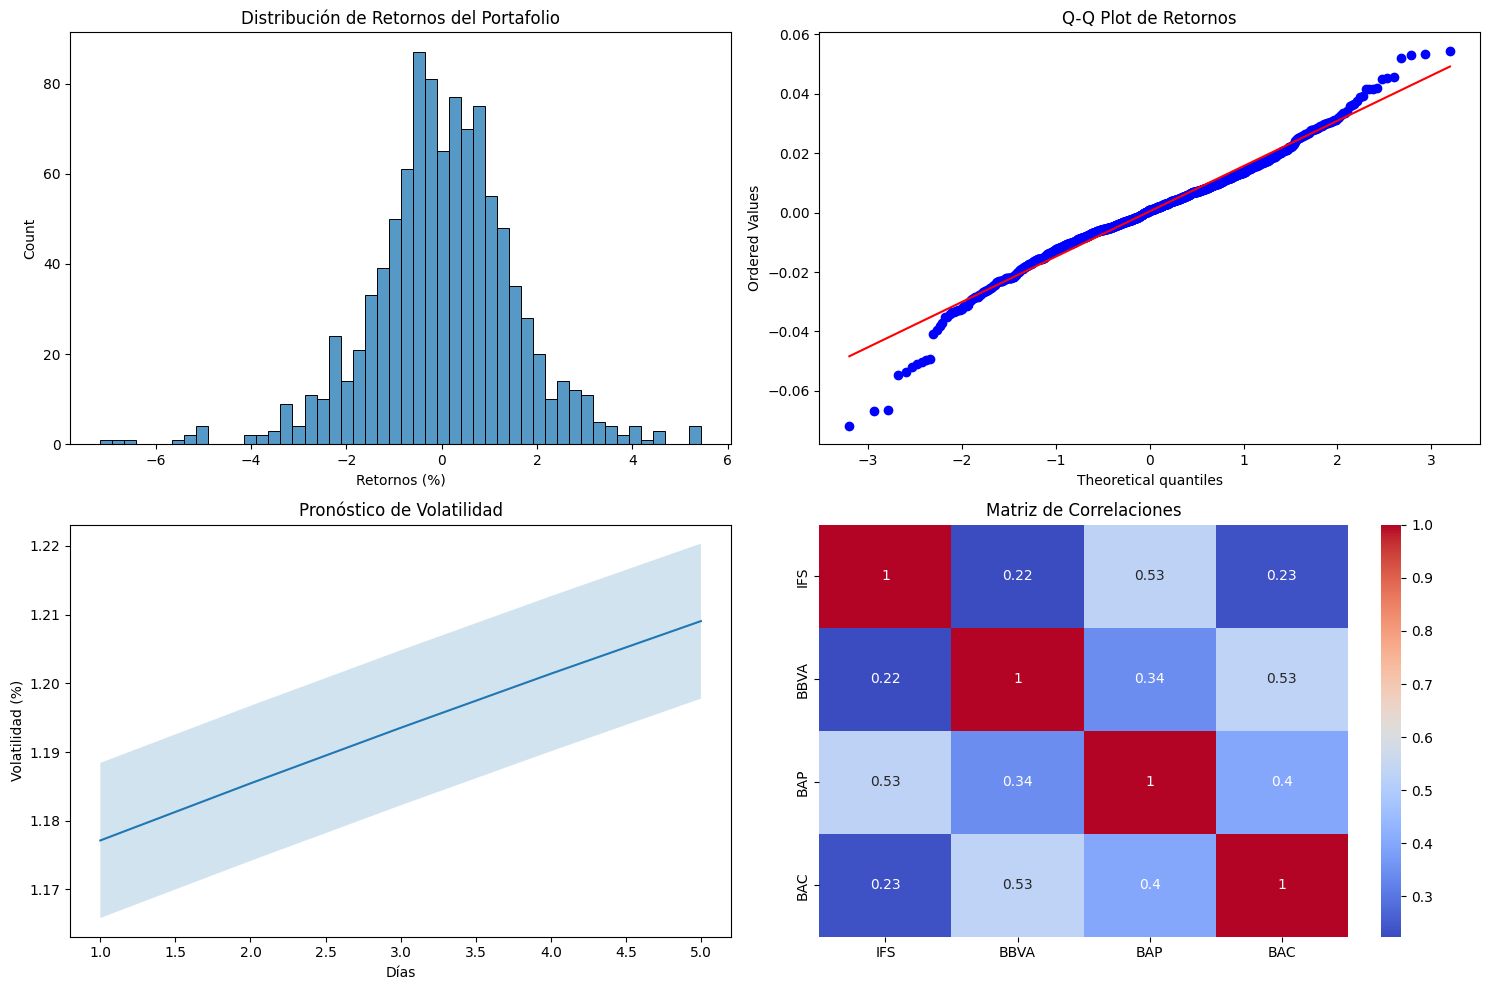

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import yfinance as yf
import matplotlib.pyplot as plt
from arch import arch_model
import seaborn as sns
from typing import List, Dict, Tuple
import logging

# Configuración de logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class MarketRiskAnalyzer:
    def __init__(self, conf_level: float = 0.99, window: int = 252):
        """
        Inicializa el analizador de riesgo de mercado.

        Args:
            conf_level: Nivel de confianza para cálculos de VaR
            window: Ventana móvil para cálculos
        """
        self.conf_level = conf_level
        self.window = window
        self.portfolio_data = None
        self.log_returns = None

    def fetch_data(self, tickers: List[str], start_date: str, end_date: str) -> pd.DataFrame:
        """
        Obtiene datos históricos de precios.
        """
        portfolio_data = pd.DataFrame()

        for ticker in tickers:
            try:
                stock = yf.download(ticker, start=start_date, end=end_date)['Close']
                if stock.empty:
                    raise ValueError(f"No se obtuvieron datos para {ticker}")
                portfolio_data[ticker] = stock
            except Exception as e:
                logging.error(f"Error al obtener datos para {ticker}: {str(e)}")
                raise

        self.portfolio_data = portfolio_data
        return portfolio_data

    def calculate_returns(self, weights: List[float]) -> pd.Series:
        """
        Calcula los retornos logarítmicos del portafolio.
        """
        if not np.isclose(sum(weights), 1.0):
            raise ValueError("Las ponderaciones deben sumar 1")

        self.log_returns = np.log(self.portfolio_data / self.portfolio_data.shift(1)).dropna()
        return np.sum(self.log_returns * weights, axis=1)

    def calculate_risk_metrics(self, portfolio_returns: pd.Series) -> Dict:
        """
        Calcula las métricas de riesgo principales.
        """
        var_99 = np.percentile(portfolio_returns, (1 - self.conf_level) * 100)
        var_parametric = portfolio_returns.mean() - stats.norm.ppf(self.conf_level) * portfolio_returns.std()
        expected_shortfall = portfolio_returns[portfolio_returns <= var_99].mean()

        rolling_vol = portfolio_returns.rolling(window=self.window).std() * np.sqrt(252)
        max_drawdown = (1 - (1 + portfolio_returns).cumprod().div(
            (1 + portfolio_returns).cumprod().cummax())).max()

        return {
            'Value at Risk': var_99 * 100,
            'Expected Shortfall': expected_shortfall * 100,
            'Maximum Drawdown': max_drawdown * 100,
            'VaR Paramétrico': var_parametric * 100,
            'Volatilidad': portfolio_returns.std() * 100,
            'Volatilidad Anualizada': portfolio_returns.std() * np.sqrt(252) * 100,
            'Asimetría': stats.skew(portfolio_returns),
            'Curtosis': stats.kurtosis(portfolio_returns)
        }

    def fit_garch(self, portfolio_returns: pd.Series, forecast_days: int = 5) -> Tuple:
        """
        Ajusta modelo GARCH y genera pronósticos.
        """
        garch_model = arch_model(portfolio_returns, vol='Garch', p=1, q=1, rescale=False)
        garch_fit = garch_model.fit(disp='off')
        forecast = garch_fit.forecast(horizon=forecast_days)
        return garch_fit, forecast

    def plot_analysis(self, portfolio_returns: pd.Series, forecast: object) -> None:
        """
        Genera visualizaciones del análisis.
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Distribución de retornos
        sns.histplot(portfolio_returns * 100, bins=50, ax=axes[0,0])
        axes[0,0].set_title('Distribución de Retornos del Portafolio')
        axes[0,0].set_xlabel('Retornos (%)')

        # QQ Plot
        stats.probplot(portfolio_returns, dist="norm", plot=axes[0,1])
        axes[0,1].set_title('Q-Q Plot de Retornos')

        # Pronóstico de volatilidad
        volatility = np.sqrt(forecast.variance.values[-1]) * 100
        axes[1,0].plot(range(1, len(volatility) + 1), volatility)
        axes[1,0].fill_between(
            range(1, len(volatility) + 1),
            volatility - volatility.std(),
            volatility + volatility.std(),
            alpha=0.2
        )
        axes[1,0].set_title('Pronóstico de Volatilidad')
        axes[1,0].set_xlabel('Días')
        axes[1,0].set_ylabel('Volatilidad (%)')

        # Matriz de correlaciones
        sns.heatmap(self.log_returns.corr(), annot=True, cmap='coolwarm', ax=axes[1,1])
        axes[1,1].set_title('Matriz de Correlaciones')

        plt.tight_layout()
        plt.show()

def main():
    # Configuración del portafolio
    portfolio = {
        'tickers': ['IFS', 'BBVA', 'BAP', 'BAC'],
        'weights': [0.3, 0.4, 0.2, 0.1],
        'start_date': '2021-01-10',
        'end_date': '2025-01-10'
    }

    try:
        # Inicializar analizador
        analyzer = MarketRiskAnalyzer()

        # Obtener datos y calcular retornos
        analyzer.fetch_data(portfolio['tickers'], portfolio['start_date'], portfolio['end_date'])
        portfolio_returns = analyzer.calculate_returns(portfolio['weights'])

        # Calcular métricas de riesgo
        metrics = analyzer.calculate_risk_metrics(portfolio_returns)

        # Ajustar modelo GARCH
        _, forecast = analyzer.fit_garch(portfolio_returns)

        # Mostrar resultados
        print("\nResultados del análisis de riesgo de mercado")
        print("-" * 50)
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

        # Generar visualizaciones
        analyzer.plot_analysis(portfolio_returns, forecast)

    except Exception as e:
        logging.error(f"Error en la ejecución: {str(e)}")
        raise

if __name__ == "__main__":
    main()